<h2><u> Modelling </u></h2>
<p> In this notebook, we train the lung segmented images on the cnn models to accurately diagonise if the scan is covid positive or not</p>
<p><b> Cnn models used:- </b></p>
<ol>
    <li>VGG16</li>
    <li>ResNet50</li>
    <li>Inception V3</li>
    <li>DenseNet169</li>
</ol>
<p> We compare the results of all the four models and select two for testing their intra dataset accuracy </p>
<p> <b>Metrics used :- </b></p>
<ol>
    <li>Accuracy and Loss Graph</li>
    <li>Classification Report (Precision,Recall,Accuracy,f1-score)</li>
    <li>Confusion Matrix</li>
    <li>ROC curve</li>
</ol>
    

In [29]:
import os
import cv2
import keras
import numpy as np
import tensorflow as tf
from keras.utils.np_utils import to_categorical
from keras.models import load_model  
#from keras.utils import plot_model
from keras import Sequential
from keras.layers import Conv2D,MaxPooling2D,Flatten,Softmax,Activation,Dense,Dropout
from keras.callbacks import Callback,ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,auc
#from skimage.transform import rescale, resize
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
import pickle
from skimage import measure
from skimage import morphology
from skimage.transform import resize
from sklearn.cluster import KMeans
from sklearn.metrics import roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
import h5py
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
from keras.models import load_model 
from keras.utils.vis_utils import plot_model
import cv2
import os
from sklearn.model_selection import train_test_split
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from learntools.core import binder
binder.bind(globals())
from learntools.computer_vision.ex2 import *
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Model
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import optimizers, losses, activations, models
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import EfficientNetB1
from keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.densenet  import DenseNet169
from keras.layers import LSTM
from keras.layers import TimeDistributed
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from learntools.core import binder
binder.bind(globals())
from learntools.computer_vision.ex2 import *
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Model
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import optimizers, losses, activations, models
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import EfficientNetB1
from keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.densenet  import DenseNet169
from keras.layers import LSTM
from keras.layers import TimeDistributed

<h3> Image Data Generator </h3>
<ol>
    <li>Used for Loading the datasets</li>
    <li>Perform Techniques like Pixel centering, Pixel Normalization and Pixel Standardization</li>
    <li>Validation Split is only used in the first dataset. It is a 70-30 split</li>
</ol>

In [2]:
covid_dir='/kaggle/input/ct-scan-dataset/Preprocessed'
SIZE_X=SIZE_Y=224
BATCH_SIZE = 128
from keras.preprocessing.image import ImageDataGenerator
datagen=ImageDataGenerator(rescale=1.0/255.0,
                           featurewise_center=True,
                           featurewise_std_normalization=True,
                           validation_split = 0.3)
training=datagen.flow_from_directory(covid_dir,
                                  class_mode = "categorical",
                                  target_size = (SIZE_X,SIZE_Y),
                                  color_mode="rgb",
                                  batch_size = 128, 
                                  shuffle = False,
                                  subset='training',
                                  seed = 42)

validation=datagen.flow_from_directory(covid_dir,
                                    class_mode = "categorical",
                                    target_size = (SIZE_X,SIZE_Y),
                                    color_mode="rgb",
                                    batch_size = 128, 
                                    shuffle = False,
                                    subset='validation',
                                    seed = 42)

Found 5601 images belonging to 2 classes.
Found 2400 images belonging to 2 classes.


<h3>&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp Vgg16 </h3>

In [3]:
def create_model(input_shape,n_classes,optimizer='adam',fine_tune=0):
    conv_base = VGG16(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False
    
    model = Sequential()
    model.add(conv_base)
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(2, activation='softmax'))
    
    model.compile(optimizer = optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [4]:
input_shape=(224,224,3)
optim_1 = Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999)
n_classes=2

n_steps=training.samples//128
n_val_steps=validation.samples//128
n_epochs=10

vggmodel=create_model(input_shape,n_classes,optim_1,fine_tune=2)
vggmodel.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                         

In [5]:
vgg_checkpoint = ModelCheckpoint(filepath='vggmodel(version1)_new.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_accuracy',
                           patience=7,
                           restore_best_weights=True,
                           mode='max')
vgg_history = vggmodel.fit(training,
                           batch_size=BATCH_SIZE,
                           epochs=30,
                           validation_data=(validation),
                           steps_per_epoch=n_steps,
                           validation_steps=n_val_steps,
                           callbacks=[vgg_checkpoint, early_stop],
                           verbose=1)

/opt/conda/lib/python3.7/site-packages/keras/preprocessing/image.py:1862: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  "This ImageDataGenerator specifies "
/opt/conda/lib/python3.7/site-packages/keras/preprocessing/image.py:1872: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  "This ImageDataGenerator specifies "


Epoch 1/30
43/43 [==============================] - ETA: 0s - loss: 3.6451 - accuracy: 0.5262
Epoch 1: val_loss improved from inf to 3.24741, saving model to vggmodel(version1)_new.weights.best.hdf5
43/43 [==============================] - 80s 1s/step - loss: 3.6451 - accuracy: 0.5262 - val_loss: 3.2474 - val_accuracy: 0.4792
Epoch 2/30
43/43 [==============================] - ETA: 0s - loss: 0.7500 - accuracy: 0.6823
Epoch 2: val_loss improved from 3.24741 to 0.41425, saving model to vggmodel(version1)_new.weights.best.hdf5
43/43 [==============================] - 33s 759ms/step - loss: 0.7500 - accuracy: 0.6823 - val_loss: 0.4143 - val_accuracy: 0.8147
Epoch 3/30
43/43 [==============================] - ETA: 0s - loss: 0.4005 - accuracy: 0.8211
Epoch 3: val_loss did not improve from 0.41425
43/43 [==============================] - 32s 743ms/step - loss: 0.4005 - accuracy: 0.8211 - val_loss: 0.9573 - val_accuracy: 0.7018
Epoch 4/30
43/43 [==============================] - ETA: 0s - lo

<h4> Accuracy and Loss Graph</h4>

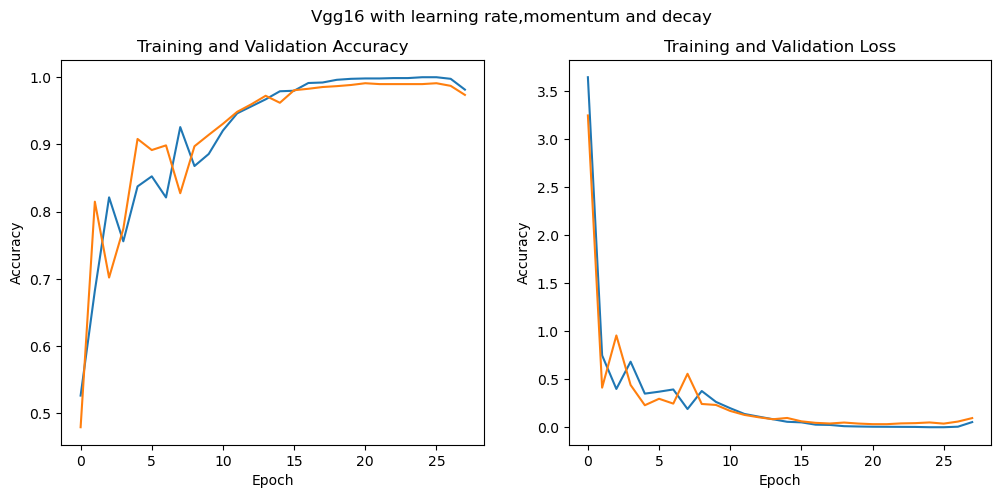

In [13]:
loss = vggmodel.history.history['loss']
accuracy = vggmodel.history.history['accuracy']
val_loss = vggmodel.history.history['val_loss']
val_accuracy = vggmodel.history.history['val_accuracy']
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
titles = ['Training and Validation Accuracy','Training and Validation Loss']
ax[0].plot(accuracy, label='Training Accuracy')
ax[0].plot(val_accuracy, label='Validation Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].set_title(titles[0], fontsize=12)

ax[1].plot(loss, label='Training Loss')
ax[1].plot(val_loss, label='Validation Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_title(titles[1], fontsize=12)

fig.suptitle('Vgg16 with learning rate,momentum and decay')
# Show the plot
plt.show()

<h4> Classification Report</h4>

In [17]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from keras.models import load_model
vggmodel = load_model(r'h5 files\vggmodel(version1)_new.weights.best.hdf5')
true_classes2 = training.classes
vgg_preds = vggmodel.predict(training)
vgg_pred_classes2 = np.argmax(vgg_preds, axis=1)
class_indices =training.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())
target= list(i for i in class_indices.values())
print(classification_report(true_classes2,vgg_pred_classes2, target_names=target))
vgg_acc = accuracy_score(true_classes2, vgg_pred_classes2)*100
print("VGG16 Accuracy Dataset1(Training) : {:.2f} %".format(vgg_acc))

/opt/conda/lib/python3.7/site-packages/keras/preprocessing/image.py:1862: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  "This ImageDataGenerator specifies "
/opt/conda/lib/python3.7/site-packages/keras/preprocessing/image.py:1872: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  "This ImageDataGenerator specifies "


44/44 [==============================] - 22s 494ms/step
              precision    recall  f1-score   support

       Covid       1.00      1.00      1.00      2801
   Non-Covid       1.00      1.00      1.00      2800

    accuracy                           1.00      5601
   macro avg       1.00      1.00      1.00      5601
weighted avg       1.00      1.00      1.00      5601

VGG16 Accuracy Dataset1(Training) : 100.00 %


In [18]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
vggmodel = load_model(r'h5 files\vggmodel(version1)_new.weights.best.hdf5') # initialize the best trained weights
true_classes = validation.classes
vgg_preds = vggmodel.predict(validation)
vgg_pred_classes = np.argmax(vgg_preds, axis=1)
class_indices = validation.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())
target= list(i for i in class_indices.values())
print(classification_report(true_classes,vgg_pred_classes, target_names=target))
vgg_acc = accuracy_score(true_classes, vgg_pred_classes)*100
print("VGG16 Accuracy Dataset1(Validation) : {:.2f} %".format(vgg_acc))

/opt/conda/lib/python3.7/site-packages/keras/preprocessing/image.py:1862: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  "This ImageDataGenerator specifies "
/opt/conda/lib/python3.7/site-packages/keras/preprocessing/image.py:1872: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  "This ImageDataGenerator specifies "


19/19 [==============================] - 17s 905ms/step
              precision    recall  f1-score   support

       Covid       0.99      0.99      0.99      1200
   Non-Covid       0.99      0.98      0.99      1200

    accuracy                           0.99      2400
   macro avg       0.99      0.99      0.99      2400
weighted avg       0.99      0.99      0.99      2400

VGG16 Accuracy Dataset1(Validation) : 98.88 %


<h4> Confusion Matrix</h4>

/opt/conda/lib/python3.7/site-packages/keras/preprocessing/image.py:1862: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  "This ImageDataGenerator specifies "
/opt/conda/lib/python3.7/site-packages/keras/preprocessing/image.py:1872: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  "This ImageDataGenerator specifies "


44/44 [==============================] - 21s 483ms/step


/opt/conda/lib/python3.7/site-packages/keras/preprocessing/image.py:1862: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  "This ImageDataGenerator specifies "
/opt/conda/lib/python3.7/site-packages/keras/preprocessing/image.py:1872: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  "This ImageDataGenerator specifies "


19/19 [==============================] - 9s 475ms/step


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


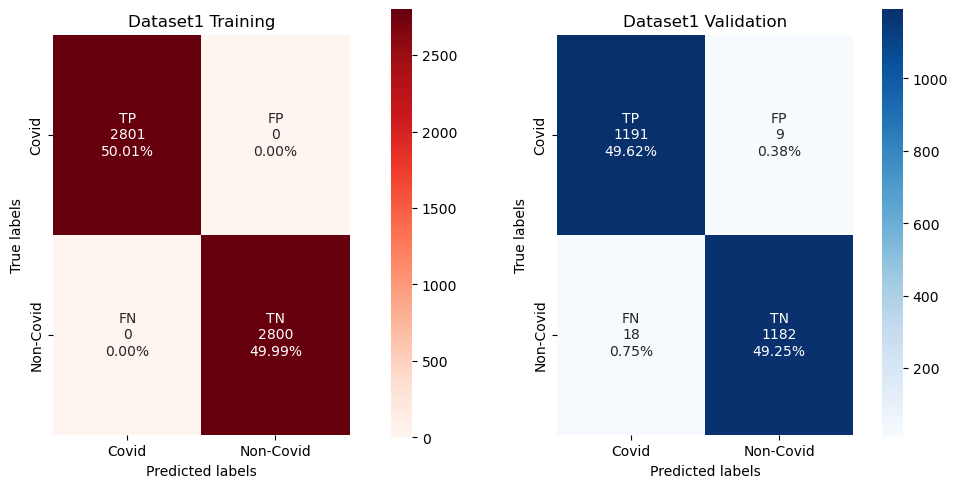

In [23]:
from sklearn.metrics import accuracy_score,confusion_matrix
import seaborn as sns
vggmodel = load_model(r'h5 files\vggmodel(version1)_new.weights.best.hdf5')
cm1 = confusion_matrix(training.classes, np.argmax(vggmodel.predict(training), axis=1))
cm2 = confusion_matrix(validation.classes, np.argmax(vggmodel.predict(validation), axis=1))
group_names = ["TP","FP","FN","TN"]
group_counts = ["{0:0.0f}".format(value) for value in cm1.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm1.flatten()/np.sum(cm1)]
Labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
Labels = np.asarray(Labels).reshape(2,2)
group_names2 = ["TP","FP","FN","TN"]
group_counts2 = ["{0:0.0f}".format(value) for value in cm2.flatten()]
group_percentages2 = ["{0:.2%}".format(value) for value in cm2.flatten()/np.sum(cm2)]
Labels2 = [f"{v11}\n{v22}\n{v33}" for v11, v22, v33 in zip(group_names2,group_counts2,group_percentages2)]
Labels2 = np.asarray(Labels2).reshape(2,2)
fig,[ax1,ax2] = plt.subplots(nrows=1,ncols=2,figsize=(10,5),constrained_layout = True)
sns.heatmap(cm1, annot=Labels, fmt='', cmap='Reds',ax=ax1)
ax1.set_xlabel('Predicted labels')
ax1.set_ylabel('True labels')
ax1.set_title("Dataset1 Training")
ax1.xaxis.set_ticklabels([target[0], target[1]]); ax1.yaxis.set_ticklabels([target[0], target[1]])
sns.heatmap(cm2, annot=Labels2, fmt='', cmap='Blues',ax=ax2)
ax2.set_xlabel('Predicted labels')
ax2.set_ylabel('True labels')
ax2.set_title("Dataset1 Validation")
ax2.xaxis.set_ticklabels([target[0], target[1]]); ax2.yaxis.set_ticklabels([target[0], target[1]])
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.7, 
                    hspace=0.7)
#fig.suptitle("This Main Title is Nicely Formatted", fontsize=16)
#fig.suptitle('VGG16+CNN Results(Confusion Matrix)')
#plt.tight_layout()
fig.show()

<h4> ROC Curve</h4>

19/19 [==============================] - 9s 483ms/step


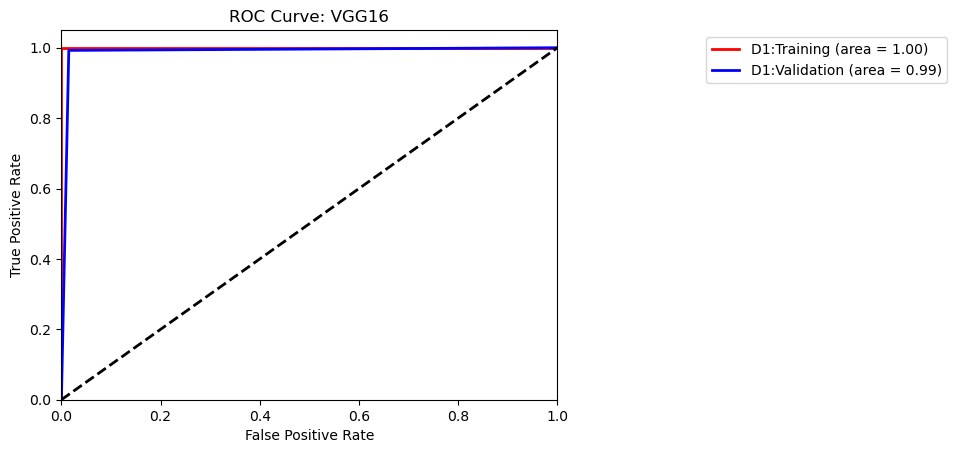

In [25]:
test_labels = training.classes
results = np.argmax(vggmodel.predict(training), axis=1)
test_labels2 = validation.classes
results2 = np.argmax(vggmodel.predict(validation), axis=1)
from scipy import interp
from itertools import cycle
from sklearn.metrics import roc_curve
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(1):
    fpr[i], tpr[i], _ = roc_curve(results,test_labels)
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr2 = dict()
tpr2 = dict()
roc_auc2 = dict()
for i in range(1):
    fpr2[i], tpr2[i], _ = roc_curve(results2,test_labels2)
    roc_auc2[i] = auc(fpr2[i], tpr2[i])
    


colors = cycle(['red', 'red'])
for i, color in zip(range(1), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='D1:Training (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
colors2 = cycle(['blue', 'blue'])
for i, color in zip(range(1), colors2):
    plt.plot(fpr2[i], tpr2[i], color=color, lw=lw,
             label='D1:Validation (area = {1:0.2f})'
             ''.format(i, roc_auc2[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: VGG16')
plt.legend(bbox_to_anchor=(1.8, 1.0), loc='upper right')
plt.show()

<h3>&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp ResNet50 </h3>

In [4]:
def create_model(input_shape,n_classes,optimizer='adam',fine_tune=0):
    conv_base = ResNet50(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False
    
    model = Sequential()
    model.add(conv_base)
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(2, activation='softmax'))
    
    model.compile(optimizer = optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [5]:
input_shape=(224,224,3)
optim_1 = Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999)
n_classes=2

n_steps=training.samples//128
n_val_steps=validation.samples//128
n_epochs=10

resnet=create_model(input_shape,n_classes,optim_1,fine_tune=2)
resnet.summary()

94765736/94765736 [==============================] - 4s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 512)               51380736  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                         

In [6]:
checkpoint = ModelCheckpoint(filepath='resnet(version1)_new.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_accuracy',
                           patience=7,
                           restore_best_weights=True,
                           mode='max')
history = resnet.fit(training,
                           batch_size=BATCH_SIZE,
                           epochs=30,
                           validation_data=(validation),
                           steps_per_epoch=n_steps,
                           validation_steps=n_val_steps,
                           callbacks=[checkpoint, early_stop],
                           verbose=1)

/opt/conda/lib/python3.7/site-packages/keras/preprocessing/image.py:1862: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  "This ImageDataGenerator specifies "
/opt/conda/lib/python3.7/site-packages/keras/preprocessing/image.py:1872: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  "This ImageDataGenerator specifies "


Epoch 1/30
43/43 [==============================] - ETA: 0s - loss: 5.5477 - accuracy: 0.4500
Epoch 1: val_loss improved from inf to 0.70703, saving model to resnet(version1)_new.weights.best.hdf5
43/43 [==============================] - 57s 1s/step - loss: 5.5477 - accuracy: 0.4500 - val_loss: 0.7070 - val_accuracy: 0.5208
Epoch 2/30
43/43 [==============================] - ETA: 0s - loss: 0.7156 - accuracy: 0.4762
Epoch 2: val_loss improved from 0.70703 to 0.69251, saving model to resnet(version1)_new.weights.best.hdf5
43/43 [==============================] - 33s 766ms/step - loss: 0.7156 - accuracy: 0.4762 - val_loss: 0.6925 - val_accuracy: 0.5208
Epoch 3/30
43/43 [==============================] - ETA: 0s - loss: 0.6941 - accuracy: 0.5118
Epoch 3: val_loss did not improve from 0.69251
43/43 [==============================] - 29s 663ms/step - loss: 0.6941 - accuracy: 0.5118 - val_loss: 0.6929 - val_accuracy: 0.5208
Epoch 4/30
43/43 [==============================] - ETA: 0s - loss: 

<h4> Accuracy and Loss Graph</h4>

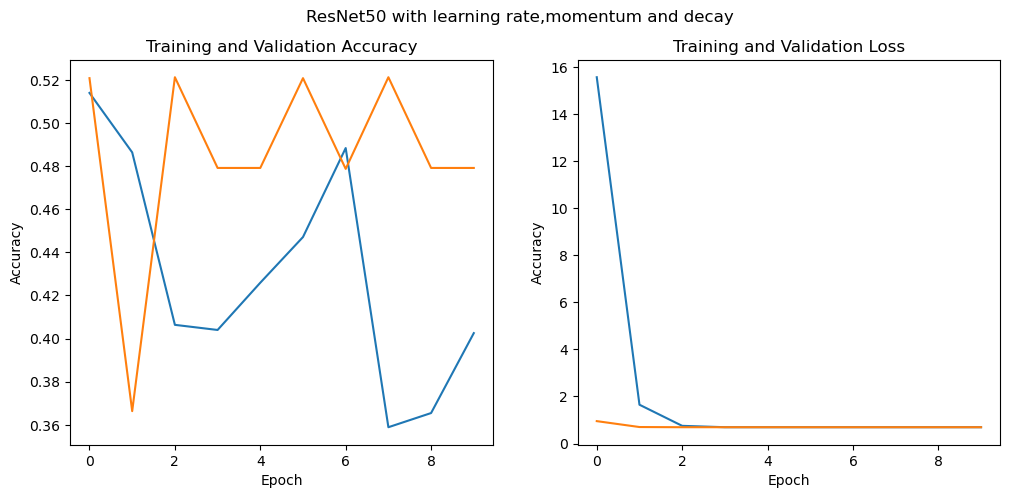

In [48]:
loss = resnet.history.history['loss']
accuracy = resnet.history.history['accuracy']
val_loss = resnet.history.history['val_loss']
val_accuracy = resnet.history.history['val_accuracy']
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
titles = ['Training and Validation Accuracy','Training and Validation Loss']
ax[0].plot(accuracy, label='Training Accuracy')
ax[0].plot(val_accuracy, label='Validation Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].set_title(titles[0], fontsize=12)

ax[1].plot(loss, label='Training Loss')
ax[1].plot(val_loss, label='Validation Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_title(titles[1], fontsize=12)

fig.suptitle('ResNet50 with learning rate,momentum and decay')
# Show the plot
plt.show()

<h4> Classification Report</h4>

In [41]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from keras.models import load_model
resnet = load_model(r'h5 files\resnet(version1)_new.weights.best.hdf5')
true_classes2 = training.classes
preds = resnet.predict(training)
pred_classes2 = np.argmax(preds, axis=1)
class_indices =training.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())
target= list(i for i in class_indices.values())
print(classification_report(true_classes2,pred_classes2, target_names=target))
acc = accuracy_score(true_classes2, pred_classes2)*100
print("ResNet50 Accuracy Dataset1(Training) : {:.2f} %".format(acc))

/opt/conda/lib/python3.7/site-packages/keras/preprocessing/image.py:1862: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  "This ImageDataGenerator specifies "
/opt/conda/lib/python3.7/site-packages/keras/preprocessing/image.py:1872: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  "This ImageDataGenerator specifies "


44/44 [==============================] - 22s 477ms/step
              precision    recall  f1-score   support

       Covid       0.00      0.00      0.00      2801
   Non-Covid       0.50      1.00      0.67      2800

    accuracy                           0.50      5601
   macro avg       0.25      0.50      0.33      5601
weighted avg       0.25      0.50      0.33      5601

ResNet50 Accuracy Dataset1(Training) : 49.99 %


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [49]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
resnet = load_model(r'h5 files\resnet(version1)_new.weights.best.hdf5') # initialize the best trained weights
true_classes = validation.classes
preds = resnet.predict(validation)
pred_classes = np.argmax(preds, axis=1)
class_indices = validation.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())
target= list(i for i in class_indices.values())
print(classification_report(true_classes,pred_classes, target_names=target))
acc = accuracy_score(true_classes, pred_classes)*100
print("ResNet50 Accuracy Dataset1(Validation) : {:.2f} %".format(acc))

19/19 [==============================] - 11s 493ms/step
              precision    recall  f1-score   support

       Covid       0.50      1.00      0.67      1200
   Non-Covid       0.00      0.00      0.00      1200

    accuracy                           0.50      2400
   macro avg       0.25      0.50      0.33      2400
weighted avg       0.25      0.50      0.33      2400

ResNet50 Accuracy Dataset1(Validation) : 50.00 %


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<h4> Confusion Matrix</h4>

/opt/conda/lib/python3.7/site-packages/keras/preprocessing/image.py:1862: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  "This ImageDataGenerator specifies "
/opt/conda/lib/python3.7/site-packages/keras/preprocessing/image.py:1872: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  "This ImageDataGenerator specifies "


44/44 [==============================] - 22s 486ms/step


/opt/conda/lib/python3.7/site-packages/keras/preprocessing/image.py:1862: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  "This ImageDataGenerator specifies "
/opt/conda/lib/python3.7/site-packages/keras/preprocessing/image.py:1872: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  "This ImageDataGenerator specifies "


19/19 [==============================] - 9s 469ms/step


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


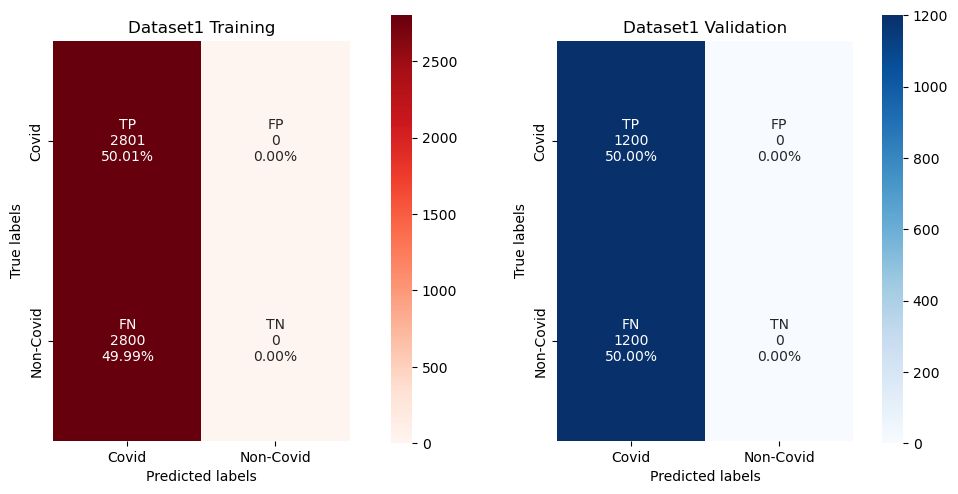

In [50]:
from sklearn.metrics import accuracy_score,confusion_matrix
import seaborn as sns
resnet = load_model(r'h5 files\resnet(version1)_new.weights.best.hdf5')
cm1 = confusion_matrix(training.classes, np.argmax(resnet.predict(training), axis=1))
cm2 = confusion_matrix(validation.classes, np.argmax(resnet.predict(validation), axis=1))
group_names = ["TP","FP","FN","TN"]
group_counts = ["{0:0.0f}".format(value) for value in cm1.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm1.flatten()/np.sum(cm1)]
Labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
Labels = np.asarray(Labels).reshape(2,2)
group_names2 = ["TP","FP","FN","TN"]
group_counts2 = ["{0:0.0f}".format(value) for value in cm2.flatten()]
group_percentages2 = ["{0:.2%}".format(value) for value in cm2.flatten()/np.sum(cm2)]
Labels2 = [f"{v11}\n{v22}\n{v33}" for v11, v22, v33 in zip(group_names2,group_counts2,group_percentages2)]
Labels2 = np.asarray(Labels2).reshape(2,2)
fig,[ax1,ax2] = plt.subplots(nrows=1,ncols=2,figsize=(10,5),constrained_layout = True)
sns.heatmap(cm1, annot=Labels, fmt='', cmap='Reds',ax=ax1)
ax1.set_xlabel('Predicted labels')
ax1.set_ylabel('True labels')
ax1.set_title("Dataset1 Training")
ax1.xaxis.set_ticklabels([target[0], target[1]]); ax1.yaxis.set_ticklabels([target[0], target[1]])
sns.heatmap(cm2, annot=Labels2, fmt='', cmap='Blues',ax=ax2)
ax2.set_xlabel('Predicted labels')
ax2.set_ylabel('True labels')
ax2.set_title("Dataset1 Validation")
ax2.xaxis.set_ticklabels([target[0], target[1]]); ax2.yaxis.set_ticklabels([target[0], target[1]])
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.7, 
                    hspace=0.7)
#fig.suptitle("This Main Title is Nicely Formatted", fontsize=16)
#fig.suptitle('VGG16+CNN Results(Confusion Matrix)')
#plt.tight_layout()
fig.show()

<h4> ROC Curve</h4>

/opt/conda/lib/python3.7/site-packages/keras/preprocessing/image.py:1862: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  "This ImageDataGenerator specifies "
/opt/conda/lib/python3.7/site-packages/keras/preprocessing/image.py:1872: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  "This ImageDataGenerator specifies "


19/19 [==============================] - 10s 531ms/step


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,


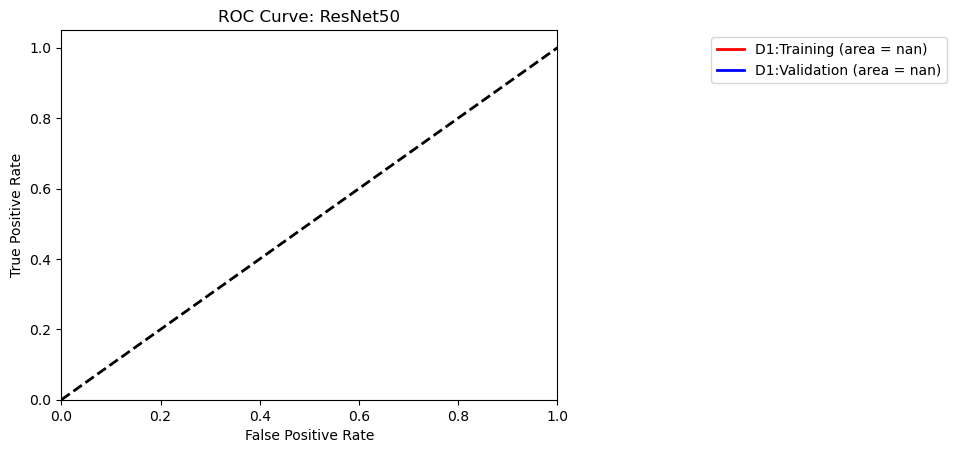

In [30]:
test_labels = training.classes
results = np.argmax(resnet.predict(training), axis=1)
test_labels2 = validation.classes
results2 = np.argmax(resnet.predict(validation), axis=1)
from scipy import interp
from itertools import cycle
from sklearn.metrics import roc_curve
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(1):
    fpr[i], tpr[i], _ = roc_curve(results,test_labels)
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr2 = dict()
tpr2 = dict()
roc_auc2 = dict()
for i in range(1):
    fpr2[i], tpr2[i], _ = roc_curve(results2,test_labels2)
    roc_auc2[i] = auc(fpr2[i], tpr2[i])
    


colors = cycle(['red', 'red'])
for i, color in zip(range(1), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='D1:Training (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
colors2 = cycle(['blue', 'blue'])
for i, color in zip(range(1), colors2):
    plt.plot(fpr2[i], tpr2[i], color=color, lw=lw,
             label='D1:Validation (area = {1:0.2f})'
             ''.format(i, roc_auc2[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: ResNet50')
plt.legend(bbox_to_anchor=(1.8, 1.0), loc='upper right')
plt.show()

<h3>&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp Inception V3 </h3>

In [9]:
def create_model(input_shape,n_classes,optimizer='adam',fine_tune=0):
    conv_base = InceptionV3(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False
    
    model = Sequential()
    model.add(conv_base)
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(2, activation='softmax'))
    
    model.compile(optimizer = optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [10]:
input_shape=(224,224,3)
optim_1 = Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999)
n_classes=2

n_steps=training.samples//128
n_val_steps=validation.samples//128
n_epochs=10

inception=create_model(input_shape,n_classes,optim_1,fine_tune=0)
inception.summary()

87910968/87910968 [==============================] - 4s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten_1 (Flatten)         (None, 51200)             0         
                                                                 
 dense_3 (Dense)             (None, 512)               26214912  
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               65664     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                       

In [11]:
checkpoint = ModelCheckpoint(filepath='inception(version1)_new.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_accuracy',
                           patience=7,
                           restore_best_weights=True,
                           mode='max')
history = inception.fit(training,
                           batch_size=BATCH_SIZE,
                           epochs=30,
                           validation_data=(validation),
                           steps_per_epoch=n_steps,
                           validation_steps=n_val_steps,
                           callbacks=[checkpoint, early_stop],
                           verbose=1)

/opt/conda/lib/python3.7/site-packages/keras/preprocessing/image.py:1862: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  "This ImageDataGenerator specifies "
/opt/conda/lib/python3.7/site-packages/keras/preprocessing/image.py:1872: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  "This ImageDataGenerator specifies "


Epoch 1/30
43/43 [==============================] - ETA: 0s - loss: 31.9909 - accuracy: 0.5480
Epoch 1: val_loss improved from inf to 1.84180, saving model to inception(version1)_new.weights.best.hdf5
43/43 [==============================] - 39s 784ms/step - loss: 31.9909 - accuracy: 0.5480 - val_loss: 1.8418 - val_accuracy: 0.5082
Epoch 2/30
43/43 [==============================] - ETA: 0s - loss: 2.6211 - accuracy: 0.6062
Epoch 2: val_loss improved from 1.84180 to 0.39332, saving model to inception(version1)_new.weights.best.hdf5
43/43 [==============================] - 30s 692ms/step - loss: 2.6211 - accuracy: 0.6062 - val_loss: 0.3933 - val_accuracy: 0.8138
Epoch 3/30
43/43 [==============================] - ETA: 0s - loss: 0.5785 - accuracy: 0.7504
Epoch 3: val_loss did not improve from 0.39332
43/43 [==============================] - 30s 707ms/step - loss: 0.5785 - accuracy: 0.7504 - val_loss: 0.4207 - val_accuracy: 0.8364
Epoch 4/30
43/43 [==============================] - ETA: 

<h4> Accuracy and Loss Graph</h4>

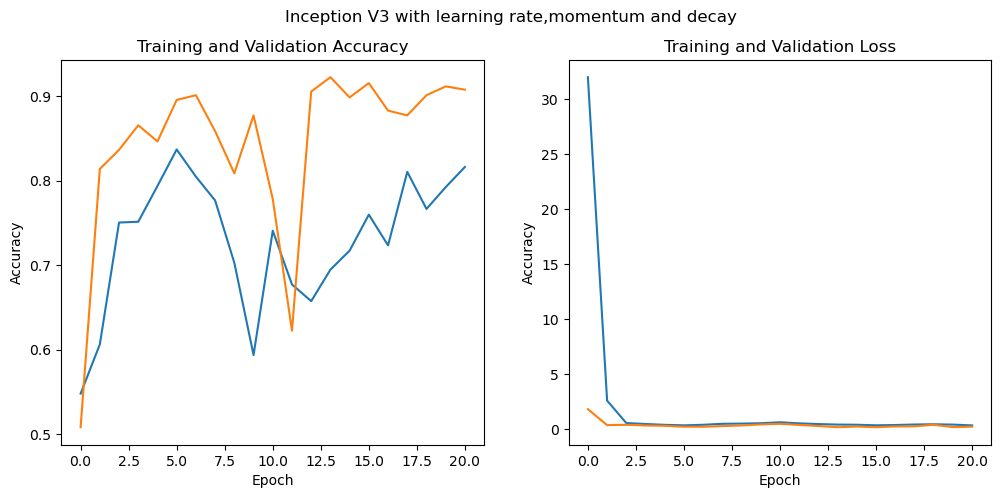

In [12]:
loss = inception.history.history['loss']
accuracy = inception.history.history['accuracy']
val_loss = inception.history.history['val_loss']
val_accuracy = inception.history.history['val_accuracy']
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
titles = ['Training and Validation Accuracy','Training and Validation Loss']
ax[0].plot(accuracy, label='Training Accuracy')
ax[0].plot(val_accuracy, label='Validation Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].set_title(titles[0], fontsize=12)

ax[1].plot(loss, label='Training Loss')
ax[1].plot(val_loss, label='Validation Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_title(titles[1], fontsize=12)

fig.suptitle('Inception V3 with learning rate,momentum and decay')
# Show the plot
plt.show()

<h4> Classification Report</h4>

In [14]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from keras.models import load_model
inception = load_model(r'h5 files\inception(version1)_new.weights.best.hdf5')
true_classes2 = training.classes
preds = inception.predict(training)
pred_classes2 = np.argmax(preds, axis=1)
class_indices =training.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())
target= list(i for i in class_indices.values())
print(classification_report(true_classes2,pred_classes2, target_names=target))
acc = accuracy_score(true_classes2, pred_classes2)*100
print("Inception V3 Accuracy Dataset1(Training) : {:.2f} %".format(acc))

/opt/conda/lib/python3.7/site-packages/keras/preprocessing/image.py:1862: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  "This ImageDataGenerator specifies "
/opt/conda/lib/python3.7/site-packages/keras/preprocessing/image.py:1872: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  "This ImageDataGenerator specifies "


44/44 [==============================] - 22s 472ms/step
              precision    recall  f1-score   support

       Covid       0.93      0.97      0.95      2801
   Non-Covid       0.97      0.92      0.95      2800

    accuracy                           0.95      5601
   macro avg       0.95      0.95      0.95      5601
weighted avg       0.95      0.95      0.95      5601

Inception V3 Accuracy Dataset1(Training) : 94.82 %


In [15]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
inception = load_model(r'h5 files\inception(version1)_new.weights.best.hdf5') # initialize the best trained weights
true_classes = validation.classes
preds = inception.predict(validation)
pred_classes = np.argmax(preds, axis=1)
class_indices = validation.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())
target= list(i for i in class_indices.values())
print(classification_report(true_classes,pred_classes, target_names=target))
acc = accuracy_score(true_classes, pred_classes)*100
print("InceptionV3 Accuracy Dataset1(Validation) : {:.2f} %".format(acc))

/opt/conda/lib/python3.7/site-packages/keras/preprocessing/image.py:1862: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  "This ImageDataGenerator specifies "
/opt/conda/lib/python3.7/site-packages/keras/preprocessing/image.py:1872: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  "This ImageDataGenerator specifies "


19/19 [==============================] - 11s 481ms/step
              precision    recall  f1-score   support

       Covid       0.90      0.95      0.92      1200
   Non-Covid       0.94      0.89      0.92      1200

    accuracy                           0.92      2400
   macro avg       0.92      0.92      0.92      2400
weighted avg       0.92      0.92      0.92      2400

InceptionV3 Accuracy Dataset1(Validation) : 92.00 %


<h4> Confusion Matrix</h4>

/opt/conda/lib/python3.7/site-packages/keras/preprocessing/image.py:1862: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  "This ImageDataGenerator specifies "
/opt/conda/lib/python3.7/site-packages/keras/preprocessing/image.py:1872: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  "This ImageDataGenerator specifies "


44/44 [==============================] - 22s 461ms/step


/opt/conda/lib/python3.7/site-packages/keras/preprocessing/image.py:1862: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  "This ImageDataGenerator specifies "
/opt/conda/lib/python3.7/site-packages/keras/preprocessing/image.py:1872: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  "This ImageDataGenerator specifies "


19/19 [==============================] - 8s 442ms/step


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


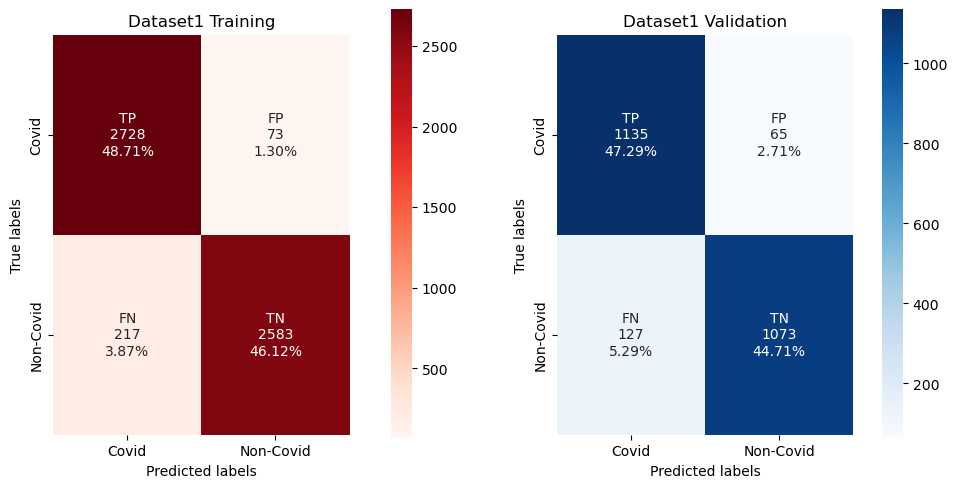

In [16]:
from sklearn.metrics import accuracy_score,confusion_matrix
import seaborn as sns
inception = load_model(r'h5 files\inception(version1)_new.weights.best.hdf5')
cm1 = confusion_matrix(training.classes, np.argmax(inception.predict(training), axis=1))
cm2 = confusion_matrix(validation.classes, np.argmax(inception.predict(validation), axis=1))
group_names = ["TP","FP","FN","TN"]
group_counts = ["{0:0.0f}".format(value) for value in cm1.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm1.flatten()/np.sum(cm1)]
Labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
Labels = np.asarray(Labels).reshape(2,2)
group_names2 = ["TP","FP","FN","TN"]
group_counts2 = ["{0:0.0f}".format(value) for value in cm2.flatten()]
group_percentages2 = ["{0:.2%}".format(value) for value in cm2.flatten()/np.sum(cm2)]
Labels2 = [f"{v11}\n{v22}\n{v33}" for v11, v22, v33 in zip(group_names2,group_counts2,group_percentages2)]
Labels2 = np.asarray(Labels2).reshape(2,2)
fig,[ax1,ax2] = plt.subplots(nrows=1,ncols=2,figsize=(10,5),constrained_layout = True)
sns.heatmap(cm1, annot=Labels, fmt='', cmap='Reds',ax=ax1)
ax1.set_xlabel('Predicted labels')
ax1.set_ylabel('True labels')
ax1.set_title("Dataset1 Training")
ax1.xaxis.set_ticklabels([target[0], target[1]]); ax1.yaxis.set_ticklabels([target[0], target[1]])
sns.heatmap(cm2, annot=Labels2, fmt='', cmap='Blues',ax=ax2)
ax2.set_xlabel('Predicted labels')
ax2.set_ylabel('True labels')
ax2.set_title("Dataset1 Validation")
ax2.xaxis.set_ticklabels([target[0], target[1]]); ax2.yaxis.set_ticklabels([target[0], target[1]])
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.7, 
                    hspace=0.7)
#fig.suptitle("This Main Title is Nicely Formatted", fontsize=16)
#fig.suptitle('VGG16+CNN Results(Confusion Matrix)')
#plt.tight_layout()
fig.show()

<h4> ROC Curve</h4>

/opt/conda/lib/python3.7/site-packages/keras/preprocessing/image.py:1862: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  "This ImageDataGenerator specifies "
/opt/conda/lib/python3.7/site-packages/keras/preprocessing/image.py:1872: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  "This ImageDataGenerator specifies "


19/19 [==============================] - 8s 445ms/step


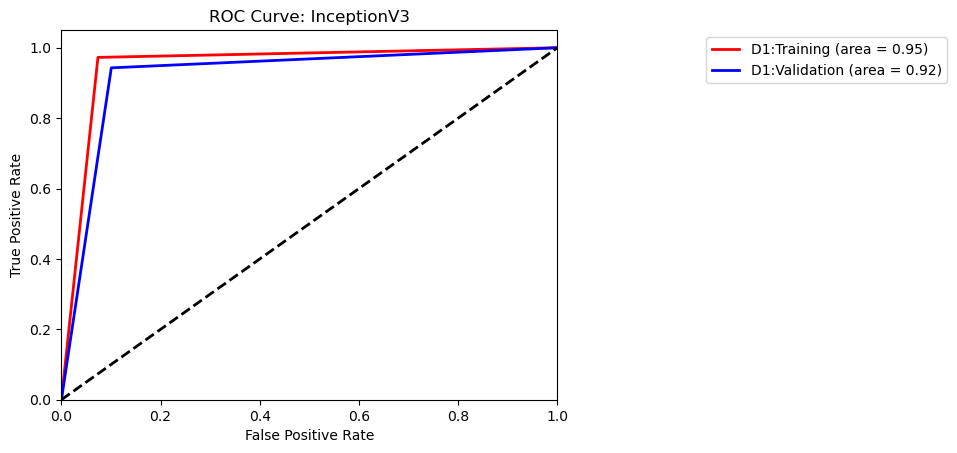

In [18]:
test_labels = training.classes
results = np.argmax(inception.predict(training), axis=1)
test_labels2 = validation.classes
results2 = np.argmax(inception.predict(validation), axis=1)
from scipy import interp
from itertools import cycle
from sklearn.metrics import roc_curve
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(1):
    fpr[i], tpr[i], _ = roc_curve(results,test_labels)
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr2 = dict()
tpr2 = dict()
roc_auc2 = dict()
for i in range(1):
    fpr2[i], tpr2[i], _ = roc_curve(results2,test_labels2)
    roc_auc2[i] = auc(fpr2[i], tpr2[i])
    


colors = cycle(['red', 'red'])
for i, color in zip(range(1), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='D1:Training (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
colors2 = cycle(['blue', 'blue'])
for i, color in zip(range(1), colors2):
    plt.plot(fpr2[i], tpr2[i], color=color, lw=lw,
             label='D1:Validation (area = {1:0.2f})'
             ''.format(i, roc_auc2[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: InceptionV3')
plt.legend(bbox_to_anchor=(1.8, 1.0), loc='upper right')
plt.show()

<h3>&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp DenseNet169 </h3>

In [20]:
def create_model(input_shape,n_classes,optimizer='adam',fine_tune=0):
    conv_base = DenseNet169(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False
    
    model = Sequential()
    model.add(conv_base)
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(2, activation='softmax'))
    
    model.compile(optimizer = optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [21]:
input_shape=(224,224,3)
optim_1 = Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999)
n_classes=2

n_steps=training.samples//128
n_val_steps=validation.samples//128
n_epochs=10

densenet=create_model(input_shape,n_classes,optim_1,fine_tune=0)
densenet.summary()

51877672/51877672 [==============================] - 3s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 flatten_2 (Flatten)         (None, 81536)             0         
                                                                 
 dense_6 (Dense)             (None, 512)               41746944  
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 128)               65664     
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                       

In [23]:
checkpoint = ModelCheckpoint(filepath='densenet(version1)_new.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_accuracy',
                           patience=7,
                           restore_best_weights=True,
                           mode='max')
history = densenet.fit(training,
                           batch_size=BATCH_SIZE,
                           epochs=30,
                           validation_data=(validation),
                           steps_per_epoch=n_steps,
                           validation_steps=n_val_steps,
                           callbacks=[checkpoint, early_stop],
                           verbose=1)

/opt/conda/lib/python3.7/site-packages/keras/preprocessing/image.py:1862: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  "This ImageDataGenerator specifies "
/opt/conda/lib/python3.7/site-packages/keras/preprocessing/image.py:1872: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  "This ImageDataGenerator specifies "


Epoch 1/30
43/43 [==============================] - ETA: 0s - loss: 24.2116 - accuracy: 0.5392
Epoch 1: val_loss improved from inf to 0.48202, saving model to densenet(version1)_new.weights.best.hdf5
43/43 [==============================] - 48s 878ms/step - loss: 24.2116 - accuracy: 0.5392 - val_loss: 0.4820 - val_accuracy: 0.8377
Epoch 2/30
43/43 [==============================] - ETA: 0s - loss: 2.9137 - accuracy: 0.6901
Epoch 2: val_loss improved from 0.48202 to 0.46961, saving model to densenet(version1)_new.weights.best.hdf5
43/43 [==============================] - 34s 796ms/step - loss: 2.9137 - accuracy: 0.6901 - val_loss: 0.4696 - val_accuracy: 0.8698
Epoch 3/30
43/43 [==============================] - ETA: 0s - loss: 0.7131 - accuracy: 0.8094
Epoch 3: val_loss improved from 0.46961 to 0.45460, saving model to densenet(version1)_new.weights.best.hdf5
43/43 [==============================] - 32s 750ms/step - loss: 0.7131 - accuracy: 0.8094 - val_loss: 0.4546 - val_accuracy: 0.79

<h4> Accuracy and Loss Graph</h4>

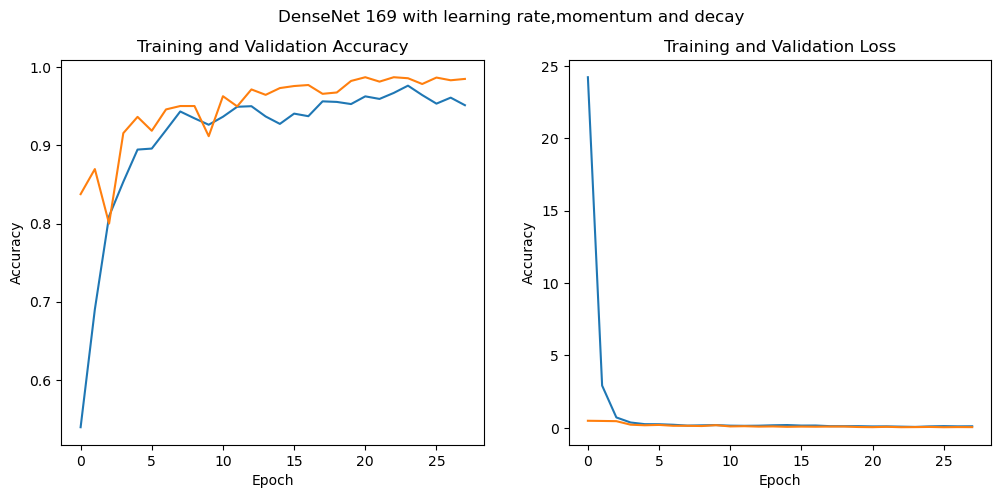

In [24]:
loss = densenet.history.history['loss']
accuracy = densenet.history.history['accuracy']
val_loss = densenet.history.history['val_loss']
val_accuracy = densenet.history.history['val_accuracy']
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
titles = ['Training and Validation Accuracy','Training and Validation Loss']
ax[0].plot(accuracy, label='Training Accuracy')
ax[0].plot(val_accuracy, label='Validation Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].set_title(titles[0], fontsize=12)

ax[1].plot(loss, label='Training Loss')
ax[1].plot(val_loss, label='Validation Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_title(titles[1], fontsize=12)

fig.suptitle('DenseNet 169 with learning rate,momentum and decay')
# Show the plot
plt.show()

<h4>Classification Report</h4>

In [25]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from keras.models import load_model
densenet = load_model(r'h5 files\densenet(version1)_new.weights.best.hdf5')
true_classes2 = training.classes
preds = densenet.predict(training)
pred_classes2 = np.argmax(preds, axis=1)
class_indices =training.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())
target= list(i for i in class_indices.values())
print(classification_report(true_classes2,pred_classes2, target_names=target))
acc = accuracy_score(true_classes2, pred_classes2)*100
print("DenseNet169 Accuracy Dataset1(Training) : {:.2f} %".format(acc))

44/44 [==============================] - 22s 452ms/step
              precision    recall  f1-score   support

       Covid       1.00      0.99      1.00      2801
   Non-Covid       0.99      1.00      1.00      2800

    accuracy                           1.00      5601
   macro avg       1.00      1.00      1.00      5601
weighted avg       1.00      1.00      1.00      5601

DenseNet169 Accuracy Dataset1(Training) : 99.68 %


In [26]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
densenet = load_model(r"h5 files\densenet(version1)_new.weights.best.hdf5") # initialize the best trained weights
true_classes = validation.classes
preds = densenet.predict(validation)
pred_classes = np.argmax(preds, axis=1)
class_indices = validation.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())
target= list(i for i in class_indices.values())
print(classification_report(true_classes,pred_classes, target_names=target))
acc = accuracy_score(true_classes, pred_classes)*100
print("DenseNet169 Accuracy Dataset1(Validation) : {:.2f} %".format(acc))

/opt/conda/lib/python3.7/site-packages/keras/preprocessing/image.py:1862: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  "This ImageDataGenerator specifies "
/opt/conda/lib/python3.7/site-packages/keras/preprocessing/image.py:1872: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  "This ImageDataGenerator specifies "


19/19 [==============================] - 12s 517ms/step
              precision    recall  f1-score   support

       Covid       0.99      0.98      0.99      1200
   Non-Covid       0.98      0.99      0.99      1200

    accuracy                           0.99      2400
   macro avg       0.99      0.99      0.99      2400
weighted avg       0.99      0.99      0.99      2400

DenseNet169 Accuracy Dataset1(Validation) : 98.71 %


<h4> Confusion Matrix</h4>

/opt/conda/lib/python3.7/site-packages/keras/preprocessing/image.py:1862: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  "This ImageDataGenerator specifies "
/opt/conda/lib/python3.7/site-packages/keras/preprocessing/image.py:1872: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  "This ImageDataGenerator specifies "


44/44 [==============================] - 23s 468ms/step


/opt/conda/lib/python3.7/site-packages/keras/preprocessing/image.py:1862: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  "This ImageDataGenerator specifies "
/opt/conda/lib/python3.7/site-packages/keras/preprocessing/image.py:1872: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  "This ImageDataGenerator specifies "


19/19 [==============================] - 9s 465ms/step


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


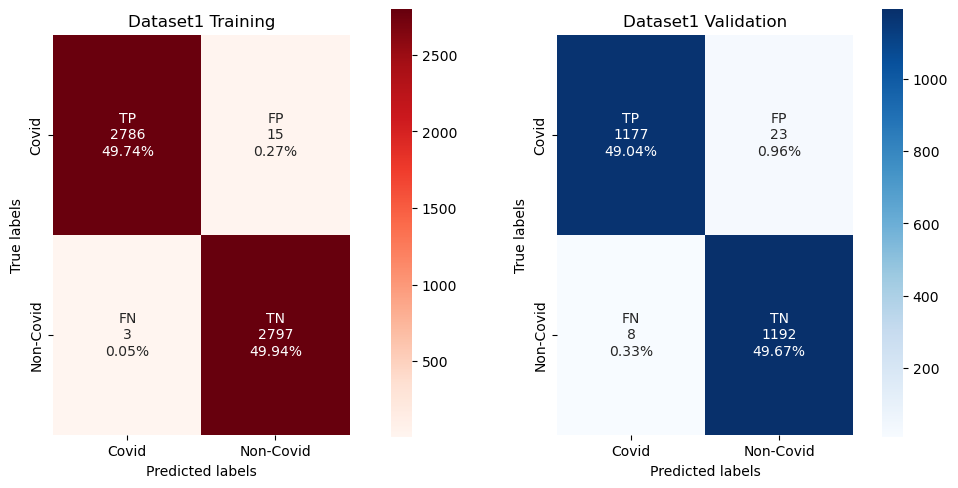

In [27]:
from sklearn.metrics import accuracy_score,confusion_matrix
import seaborn as sns
densenet = load_model(r'h5 files\densenet(version1)_new.weights.best.hdf5')
cm1 = confusion_matrix(training.classes, np.argmax(densenet.predict(training), axis=1))
cm2 = confusion_matrix(validation.classes, np.argmax(densenet.predict(validation), axis=1))
group_names = ["TP","FP","FN","TN"]
group_counts = ["{0:0.0f}".format(value) for value in cm1.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm1.flatten()/np.sum(cm1)]
Labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
Labels = np.asarray(Labels).reshape(2,2)
group_names2 = ["TP","FP","FN","TN"]
group_counts2 = ["{0:0.0f}".format(value) for value in cm2.flatten()]
group_percentages2 = ["{0:.2%}".format(value) for value in cm2.flatten()/np.sum(cm2)]
Labels2 = [f"{v11}\n{v22}\n{v33}" for v11, v22, v33 in zip(group_names2,group_counts2,group_percentages2)]
Labels2 = np.asarray(Labels2).reshape(2,2)
fig,[ax1,ax2] = plt.subplots(nrows=1,ncols=2,figsize=(10,5),constrained_layout = True)
sns.heatmap(cm1, annot=Labels, fmt='', cmap='Reds',ax=ax1)
ax1.set_xlabel('Predicted labels')
ax1.set_ylabel('True labels')
ax1.set_title("Dataset1 Training")
ax1.xaxis.set_ticklabels([target[0], target[1]]); ax1.yaxis.set_ticklabels([target[0], target[1]])
sns.heatmap(cm2, annot=Labels2, fmt='', cmap='Blues',ax=ax2)
ax2.set_xlabel('Predicted labels')
ax2.set_ylabel('True labels')
ax2.set_title("Dataset1 Validation")
ax2.xaxis.set_ticklabels([target[0], target[1]]); ax2.yaxis.set_ticklabels([target[0], target[1]])
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.7, 
                    hspace=0.7)
#fig.suptitle("This Main Title is Nicely Formatted", fontsize=16)
#fig.suptitle('VGG16+CNN Results(Confusion Matrix)')
#plt.tight_layout()
fig.show()

<h4> ROC Curve</h4>

/opt/conda/lib/python3.7/site-packages/keras/preprocessing/image.py:1862: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  "This ImageDataGenerator specifies "
/opt/conda/lib/python3.7/site-packages/keras/preprocessing/image.py:1872: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  "This ImageDataGenerator specifies "


19/19 [==============================] - 8s 441ms/step


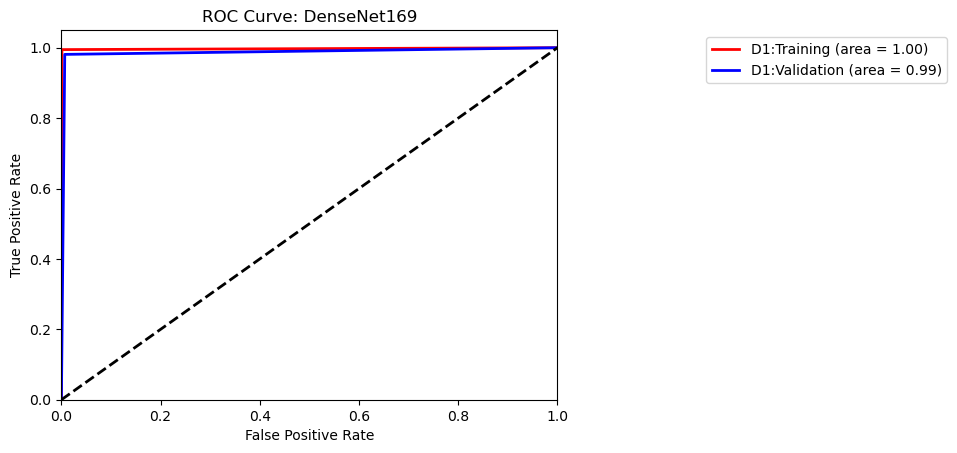

In [28]:
test_labels = training.classes
results = np.argmax(densenet.predict(training), axis=1)
test_labels2 = validation.classes
results2 = np.argmax(densenet.predict(validation), axis=1)
from scipy import interp
from itertools import cycle
from sklearn.metrics import roc_curve
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(1):
    fpr[i], tpr[i], _ = roc_curve(results,test_labels)
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr2 = dict()
tpr2 = dict()
roc_auc2 = dict()
for i in range(1):
    fpr2[i], tpr2[i], _ = roc_curve(results2,test_labels2)
    roc_auc2[i] = auc(fpr2[i], tpr2[i])
    


colors = cycle(['red', 'red'])
for i, color in zip(range(1), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='D1:Training (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
colors2 = cycle(['blue', 'blue'])
for i, color in zip(range(1), colors2):
    plt.plot(fpr2[i], tpr2[i], color=color, lw=lw,
             label='D1:Validation (area = {1:0.2f})'
             ''.format(i, roc_auc2[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: DenseNet169')
plt.legend(bbox_to_anchor=(1.8, 1.0), loc='upper right')
plt.show()